In [1]:
import pandas as pd
import numpy as np
import os
from functools import reduce
import random
import re
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

from Bio import *
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB import PDBIO

# Set the Seaborn parameters
sns.set(style='whitegrid', color_codes=True, font='sans-serif', font_scale=1.5)

In [2]:
# Block of seaborn style settings
plt.rc('font', size=23) #controls default text size
plt.rc('axes', labelsize=15) #fontsize of the x and y labels
plt.rc('xtick', labelsize=12) #fontsize of the x tick labels
plt.rc('ytick', labelsize=12) #fontsize of the y tick labels
sns.set(style='whitegrid', color_codes=True, font='serif', font_scale=2)

In [3]:
output_path = '/lustre/hpc/sbinlab/panf/SKEMPIv2/Cart_ddG_run_dir'
input_path = '/lustre/hpc/sbinlab/panf/SKEMPIv2/input_pdbs/main'
zemu = pd.read_csv('/groups/sbinlab/panf/SKEMPIv2/skempi2_filt.csv')
zemu.drop(columns=['Unnamed: 0', 'case_name', 'ddG_bind'], inplace=True)
zemu.drop(columns=['Reference', 'kon_mut (M^(-1)s^(-1))', 'kon_mut_parsed',
 'kon_wt (M^(-1)s^(-1))', 'kon_wt_parsed', 'koff_mut (s^(-1))','koff_mut_parsed',
 'koff_wt (s^(-1))', 'koff_wt_parsed','dH_mut (kcal mol^(-1))', 'dH_wt (kcal mol^(-1))',
 'dS_mut (cal mol^(-1) K^(-1))', 'dS_wt (cal mol^(-1) K^(-1))', 'Notes'], inplace=True)
zemu = zemu.loc[zemu['Chains'].str.len()==2].reset_index(drop=True)
# Drop non-binders?
zemu = zemu.loc[~zemu['Affinity_mut_parsed'].isna()]
zemu = zemu.loc[~zemu['Affinity_wt_parsed'].isna()].reset_index(drop=True)
#zemu = zemu.loc[zemu['Mutation(s)_PDB'].str.split(',').str.len() == 1].copy().reset_index(drop=True)

In [4]:
output_path = '/lustre/hpc/sbinlab/panf/SKEMPIv2/Cart_ddG_beta_new'
input_path = '/lustre/hpc/sbinlab/panf/SKEMPIv2/input_pdbs/main'
zemu = pd.read_csv('/groups/sbinlab/panf/SKEMPIv2/skempi2_mesure_mean.csv')
zemu.drop(columns=['ddG_bind'], inplace=True)
zemu.drop(columns=['Reference', 'kon_mut (M^(-1)s^(-1))', 'kon_mut_parsed',
 'kon_wt (M^(-1)s^(-1))', 'kon_wt_parsed', 'koff_mut (s^(-1))','koff_mut_parsed',
 'koff_wt (s^(-1))', 'koff_wt_parsed','dH_mut (kcal mol^(-1))', 'dH_wt (kcal mol^(-1))',
 'dS_mut (cal mol^(-1) K^(-1))', 'dS_wt (cal mol^(-1) K^(-1))', 'Notes'], inplace=True)
zemu = zemu.loc[zemu['Chains'].str.len()==2].reset_index(drop=True)
# Drop non-binders?
zemu = zemu.loc[~zemu['Affinity_mut_parsed'].isna()]
zemu = zemu.loc[~zemu['Affinity_wt_parsed'].isna()].reset_index(drop=True)
#zemu = zemu.loc[zemu['Mutation(s)_PDB'].str.split(',').str.len() == 1].copy().reset_index(drop=True)

zemu.drop_duplicates(inplace=True)

In [5]:
# Filter out entries with stndard deviation < 0.5 across multiple measurements
zemu['dG_bind_MUT_std'].fillna(0, inplace=True)
zemu['dG_bind_WT_std'].fillna(0, inplace=True)
low_err = zemu.loc[(zemu['dG_bind_MUT_std']<0.5)&(zemu['dG_bind_WT_std']<0.5)].copy()

groups = low_err[['#Pdb', 'Mutation(s)_PDB', 'dG_bind_MUT', 'dG_bind_WT']].groupby(['#Pdb', 'Mutation(s)_PDB'])
group_mean = groups.mean()
low_err.drop(columns=['dG_bind_MUT', 'dG_bind_WT'], inplace=True)

zemu = pd.merge(low_err, group_mean, on=['#Pdb', 'Mutation(s)_PDB'])
zemu['ddG_bind'] = zemu['dG_bind_MUT'].values - zemu['dG_bind_WT'].values
zemu.drop_duplicates(subset=['#Pdb', 'Mutation(s)_PDB'], inplace=True)
zemu.drop(columns=['dG_bind_MUT_std', 'dG_bind_WT_std'], inplace=True)

KeyError: 'dG_bind_MUT_std'

In [53]:
flex_ddg = pd.read_csv('/groups/sbinlab/panf/SKEMPIv2/Flex_ddG_analysis/Flex_ddG_output-results.csv', usecols=['case_name', 'score_function_name', 'total_score','std', 'scored_state'])
flex_ddg.rename(columns={'case_name': 'PDBFileID'}, inplace=True)
flex_ddg.drop_duplicates(inplace=True)
total = flex_ddg.loc[(flex_ddg['score_function_name']=='fa_talaris2014')&(flex_ddg['scored_state'].isna())].copy().reset_index(drop=True).drop(columns=['scored_state', 'score_function_name'])
total_gam = flex_ddg.loc[(flex_ddg['score_function_name']=='fa_talaris2014-gam')&(flex_ddg['scored_state'].isna())].copy().reset_index(drop=True).drop(columns=['scored_state', 'score_function_name'])

In [96]:
#zemu = zemu.loc[zemu['Mutation(s)_PDB'].str.split(',').str.len() == 1].copy().reset_index(drop=True)

In [6]:
## Loading the data

# Creating lists to store cart_ddG output stored as dfs
ddG_df_list_complex = list()
# Creating lists to store names of PDBs with empty output folders
no_output = list()

# Going through contents of run dir
for folder in os.listdir(output_path):
    # If item is not a slurm file or a Jupyter checkpoint file, it's a folder with cart_ddG run files
    # Save path to 'output' folder in cart_ddG PDB run folder. This is the path to ddG_complex calculations.
    if not folder.startswith('.ipynb_') | folder.endswith('.out'):
        path_to_output = os.path.join(output_path, folder, "output")
        path_to_pdb = os.path.join(output_path, folder)
        # If 'output' folder is not empty, read prism file, add PDBFileID column (by folder name), append list of dfs
        if len(os.listdir(path_to_output)) > 0:
            for file in os.listdir(path_to_output):
                if file.startswith('prism_'):
                    path_to_prism = os.path.join(path_to_output, file)
                    x = pd.read_csv(path_to_prism, sep=" ", comment='#')
                    x['PDB_ID'] = folder
                    ddG_df_list_complex.append(x)
        # If 'output' folder is empty, add PDB name to no_output list
        else:
            no_output.append(folder)

# Concatenate list of dfs into one for ddG_complex
all_cases_muts = pd.concat(ddG_df_list_complex)
variants = all_cases_muts[~all_cases_muts.variant.str.contains(r'=')].copy()
variants.reset_index(drop=True, inplace=True)

In [9]:
variants_ref

,variant,mean_ddG,std_ddG,PDB_ID
0,L138A,4.228621,0.000000,4HRN
1,S164A,-0.429195,0.000000,4HRN
2,V165A,1.741379,0.001138,4HRN
3,F168A,4.283448,0.000325,4HRN
4,Q128K,1.066552,0.000650,1FY8
...,...,...,...,...
2111,Q1020A,0.665747,0.098426,3M62
2112,V1022A,1.641379,0.035130,3M62
2113,M1024A,1.514023,0.000905,3M62
2114,G225D,1.966437,0.087210,2A9K


In [10]:
test= pd.merge(variants_ref, variants, on=['PDB_ID', 'variant'], suffixes=('_ref', '_beta'))

In [11]:
#variants.to_csv('cart_ddg_ref2015_2chains_interface_mode_filt.csv', index=False)

In [47]:
test

,variant,mean_ddG_ref,std_ddG_ref,PDB_ID,mean_ddG_beta,std_ddG_beta
0,L138A,4.228621,0.000000,4HRN,4.597241,0.000000
1,S164A,-0.429195,0.000000,4HRN,-0.535517,0.000000
2,V165A,1.741379,0.001138,4HRN,1.554483,0.003460
3,F168A,4.283448,0.000325,4HRN,4.731609,0.000000
4,Q128K,1.066552,0.000650,1FY8,1.161609,0.003739
...,...,...,...,...,...,...
2051,Q1020A,0.665747,0.098426,3M62,1.155287,0.006688
2052,V1022A,1.641379,0.035130,3M62,1.610460,0.009964
2053,M1024A,1.514023,0.000905,3M62,0.937586,0.001270
2054,G225D,1.966437,0.087210,2A9K,1.498621,1.461194


In [8]:
variants_ref= pd.read_csv('cart_ddg_ref2015_2chains_interface_mode_filt.csv')

In [11]:
# Renumbering the residues from Rosetta numeration to chain + num for the whole PDB

dict_of_dicts = {}
for folder_pdb in os.listdir(input_path):
    folder_pdb_path = os.path.join(input_path, folder_pdb)
    for file in os.listdir(folder_pdb_path):
        if file.startswith('Cleaned'):
                pdb_path = os.path.join(folder_pdb_path, file)
    pdb_file = open(pdb_path, 'r')
    lines = pdb_file.readlines()
    raa_prev = ''
    rn_pres = ''
    pos_chain = {}
    pos_add = 1
    for line in lines:
        if line.startswith('ATOM'):
            if (line[17:20] != raa_prev)|(line[22:27] != rn_pres):
                chain_num = line[21] + ' ' + line[22:27].strip(' ').lower()
                pos_chain[chain_num] = pos_add
                raa_prev = line[17:20]
                rn_pres = line[22:27]
                pos_add += 1
    pdb_file.close()
    dict_of_dicts[folder_pdb] = pos_chain
    
# # Renumbering the residues from Rosetta numeration to chain + num for one specific chain

# dict_of_dicts_per_chain = {}
# for folder_pdb in os.listdir(input_path):
#     folder_pdb_path = os.path.join(input_path, folder_pdb)
#     for file in os.listdir(folder_pdb_path):
#         if file.startswith('Cleaned'):
#                 pdb_path = os.path.join(folder_pdb_path, file)
#     pdb_file = open(pdb_path, 'r')
#     lines = pdb_file.readlines()
#     raa_prev = ''
#     rn_pres = ''
#     pos_chain = {}
#     pos_add = 1
#     for index, line in enumerate(lines):
#         if line.startswith('ATOM'):
#             if (line[17:20] != raa_prev)|(line[22:27] != rn_pres):
#                 chain_num = line[21] + ' ' + line[22:27].strip(' ').lower()
#                 pos_chain[chain_num] = pos_add
#                 raa_prev = line[17:20]
#                 rn_pres = line[22:27]
#                 pos_add += 1
#                 chain = line[21]
#         if line.startswith('TER'):
#             dict_of_dicts_per_chain[folder_pdb + '_' + chain] = pos_chain
#             pos_add = 1
#             pos_chain = {}            
#     pdb_file.close()

In [12]:
# Renumbering resfile notation to prism output notation

# Go through the dataframe row by row. Get PDB id for every case and mutations as a list. Define list to append reformated mutations to.
reformat_muts = list()
for index, row in zemu.iterrows():
    pdb = row['PDB_ID']
    list_mut = row['Mutation(s)_PDB'].split(',')
    # string_full_mut = ''
    list_full_mut = list()
    count = 0
# Go through mutations and append reformated mutations to the list
    for mut in list_mut:
        count += 1
        pos = mut[2:-1]
        chain = mut[1]
        sub = mut[-1]     
        wt = mut[0]
        word = chain + ' ' + pos
        # For every mutation, look in the dictionary for chain plus position and translate to Rosetta numeration
        translation = str(dict_of_dicts[pdb][word])
        prism_format = wt + translation + sub
        if prism_format not in list_full_mut:
            list_full_mut.append(prism_format)
    list_full_mut.sort(key = lambda x: int(x[1:-1]))
    delim = ":"
    # using map to convert each element to string
    temp = list(map(str, list_full_mut))
    # join() used to join with delimiter
    string_full_mut = delim.join(temp)
    reformat_muts.append(string_full_mut)

In [13]:
zemu['variant'] = reformat_muts

In [14]:
exp_cart_ddG_all = pd.merge(variants, zemu, on=['PDB_ID', 'variant'], how='left')

In [60]:
exp_cart_ddG_all = pd.merge(test, zemu, on=['PDB_ID', 'variant'], how='left')

In [18]:
exp_cart_ddG_all['ddG_bind'] = exp_cart_ddG_all['dG_bind_MUT']-exp_cart_ddG_all['dG_bind_WT']

In [19]:
exp_cart_ddG_all = exp_cart_ddG_all.loc[~exp_cart_ddG_all['ddG_bind'].isna()]

In [23]:
exp_cart_ddG_all.loc[exp_cart_ddG_all['PDB_ID'].isin(['1JTG', '5E9D', '3SZK', '3BN9', '2J0T', '1KTZ', '3SGB', '3MZG', '1DAN', '1VFB', '1OGA'])]

,variant,mean_ddG,std_ddG,PDB_ID,#Pdb,Mutation(s)_PDB,Mutation(s)_cleaned,iMutation_Location(s),Hold_out_type,Hold_out_proteins,...,Method,SKEMPI version,dG_bind_MUT,dG_bind_WT,LChains,RChains,Chains,index,case_ID,ddG_bind
46,R13A,1.477356,0.002601,1KTZ,1KTZ_A_B,RA25A,RA13A,RIM,NaN,"1KTZ_A_B,1REW_AB_C,2QJ9_AB_C,2QJA_AB_C,2QJB_AB...",...,SPR,1.0,-8.250373,-9.731291,A,B,AB,648.0,648_1KTZ,1.480918
47,R13K,1.067816,0.000000,1KTZ,1KTZ_A_B,RA25K,RA13K,RIM,NaN,"1KTZ_A_B,1REW_AB_C,2QJ9_AB_C,2QJA_AB_C,2QJB_AB...",...,SPR,1.0,-8.580109,-9.731291,A,B,AB,646.0,646_1KTZ,1.151182
48,V62I,-0.108966,0.000000,1KTZ,1KTZ_A_B,VA92I,VA62I,COR,NaN,"1KTZ_A_B,1REW_AB_C,2QJ9_AB_C,2QJA_AB_C,2QJB_AB...",...,SPR,1.0,-9.488482,-9.731291,A,B,AB,645.0,645_1KTZ,0.242809
49,R64A,0.662759,0.000975,1KTZ,1KTZ_A_B,RA94A,RA64A,RIM,NaN,"1KTZ_A_B,1REW_AB_C,2QJ9_AB_C,2QJA_AB_C,2QJB_AB...",...,SPR,1.0,-6.848178,-9.731291,A,B,AB,649.0,649_1KTZ,2.883113
50,R64K,0.300000,0.043657,1KTZ,1KTZ_A_B,RA94K,RA64K,RIM,NaN,"1KTZ_A_B,1REW_AB_C,2QJ9_AB_C,2QJA_AB_C,2QJB_AB...",...,SPR,1.0,-7.530779,-9.731291,A,B,AB,647.0,647_1KTZ,2.200512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2708,N215S,0.927931,0.000000,3SGB,3SGB_E_I,NI36S,NI30S,RIM,Pr/PI,Pr/PI,...,FL,1.0,-14.054353,-14.457682,E,I,EI,2499.0,2499_3SGB,0.403329
2709,N215T,0.436897,0.000000,3SGB,3SGB_E_I,NI36T,NI30T,RIM,Pr/PI,Pr/PI,...,FL,1.0,-14.447971,-14.457682,E,I,EI,2502.0,2502_3SGB,0.009711
2710,N215V,-0.835517,0.000000,3SGB,3SGB_E_I,NI36V,NI30V,RIM,Pr/PI,Pr/PI,...,FL,1.0,-14.696204,-14.457682,E,I,EI,2501.0,2501_3SGB,-0.238522
2711,N215W,-0.957931,0.000000,3SGB,3SGB_E_I,NI36W,NI30W,RIM,Pr/PI,Pr/PI,...,FL,1.0,-13.938902,-14.457682,E,I,EI,2515.0,2515_3SGB,0.518780


In [25]:
zemu.loc[zemu['PDB_ID']=='1DAN']

,#Pdb,Mutation(s)_PDB,Mutation(s)_cleaned,iMutation_Location(s),Hold_out_type,Hold_out_proteins,Affinity_mut (M),Affinity_mut_parsed,Affinity_wt (M),Affinity_wt_parsed,...,SKEMPI version,dG_bind_MUT,dG_bind_WT,PDB_ID,LChains,RChains,Chains,index,case_ID,variant


Text(10, -12, '$\\rho = 0.524$')

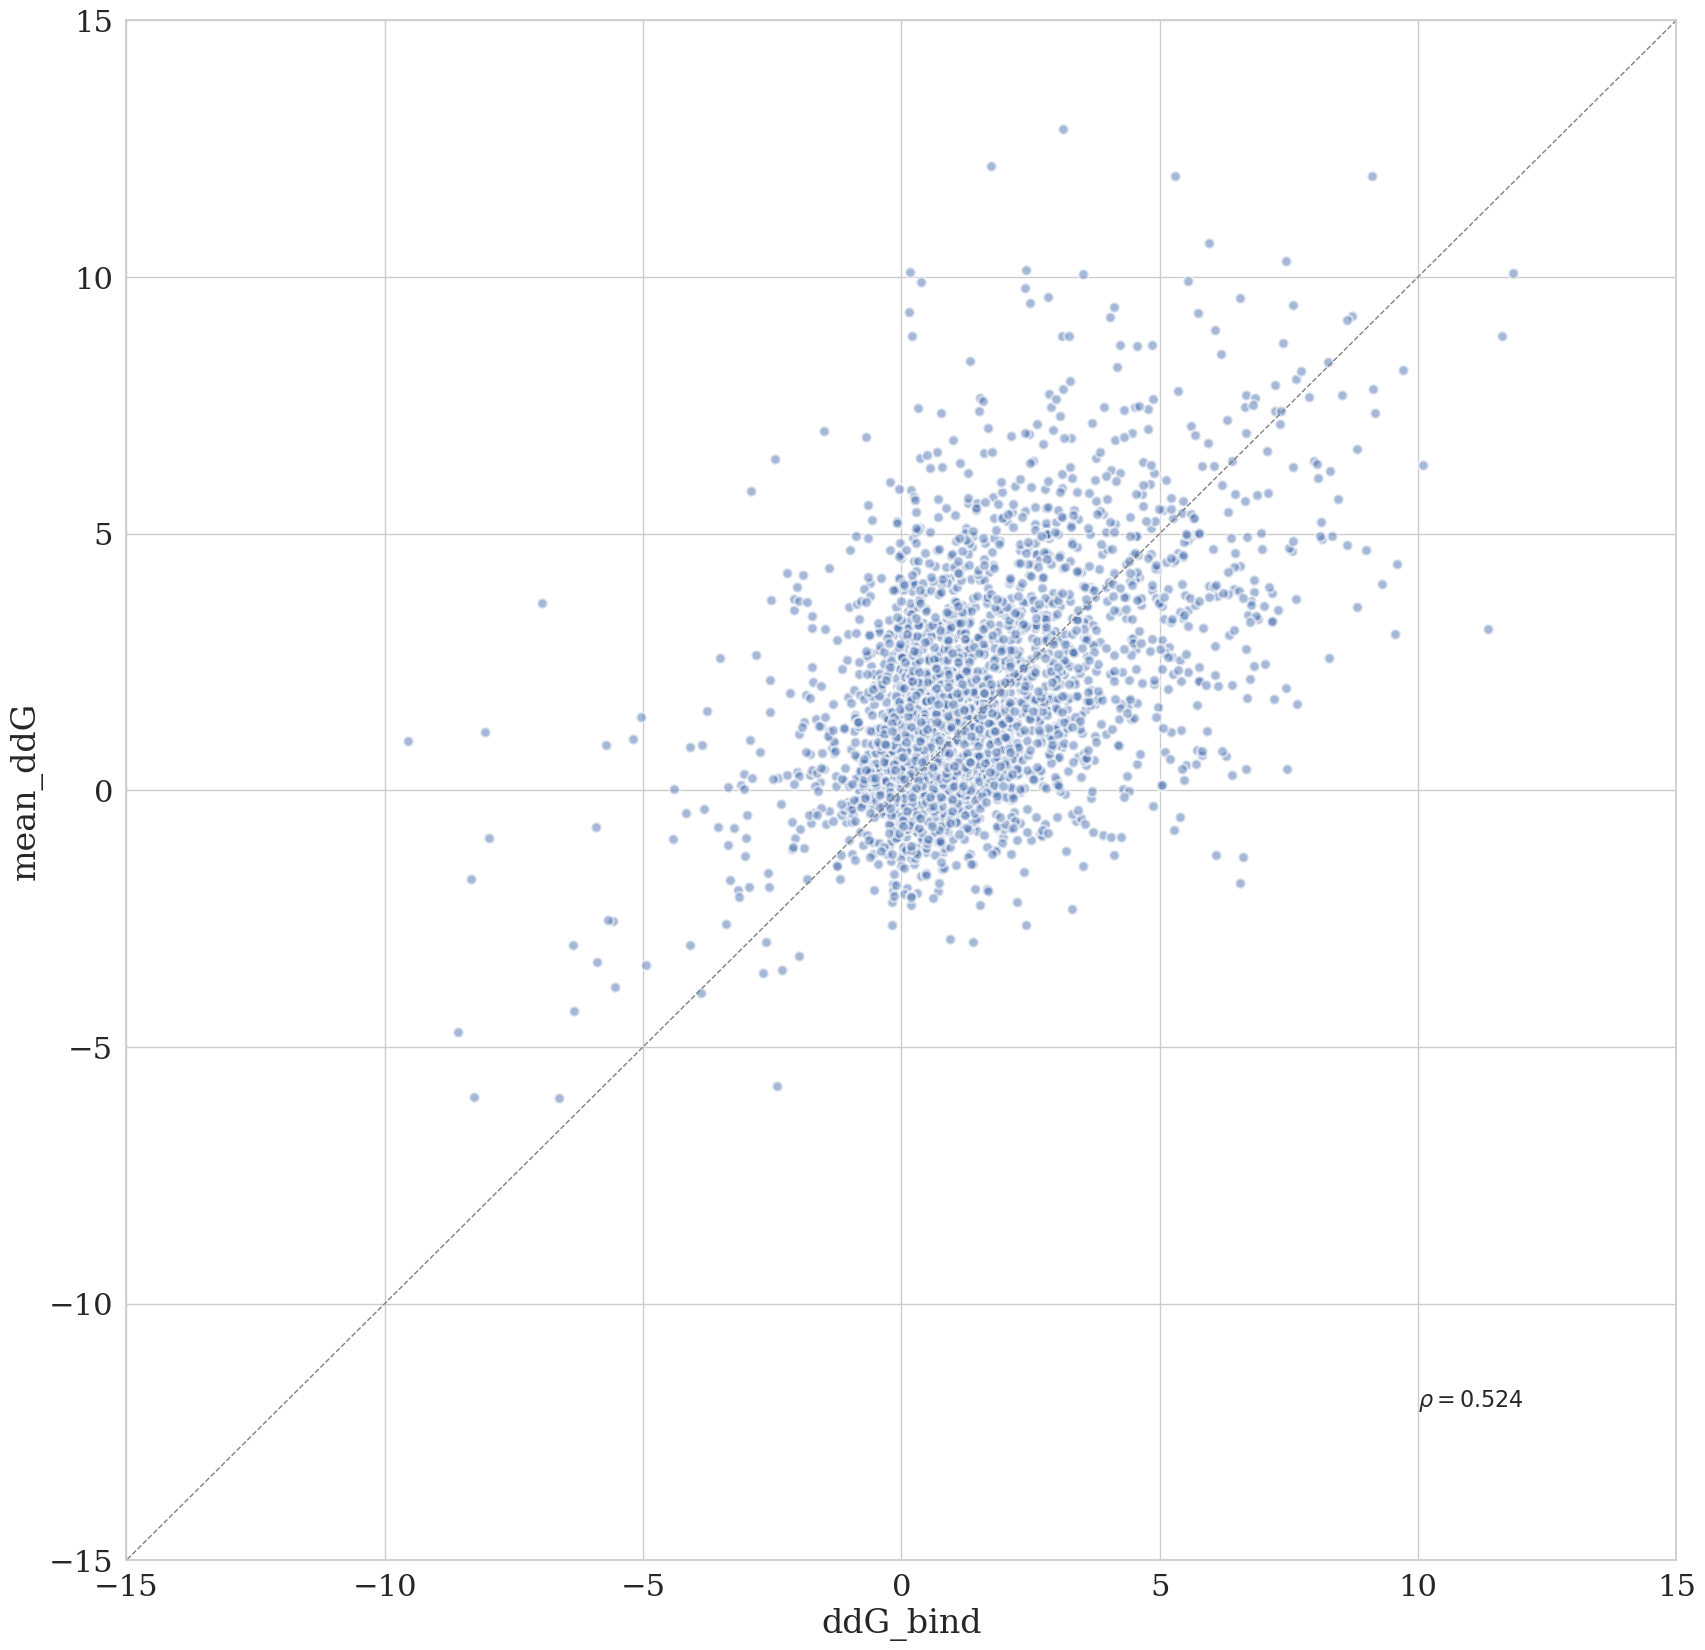

In [22]:
fig, axes = plt.subplots(1,1, figsize = (20,20))
plt.setp(axes, xlim=(-15, 15), ylim=(-15, 15))
# Create the scatter plot

plot = sns.scatterplot(x=plot_data.dropna()['ddG_bind'],
                       y=plot_data.dropna()['mean_ddG'],
                       alpha=0.5, s=55, linewidth=2)

min_val = -15 - 1.5
max_val = 15 + 1.5
axes.plot([min_val, max_val], [min_val, max_val], color='gray', ls='--', lw=1)
r, p = stats.pearsonr(plot_data.dropna()['ddG_bind'],
                      plot_data.dropna()['mean_ddG'])
axes.annotate(f'$\\rho = {r:.3f}$', xy=(10, -12), fontsize = 16)

In [21]:
plot_data = exp_cart_ddG_all[['PDB_ID', 'case_ID', 'variant', 'mean_ddG', 'std_ddG', 'ddG_bind']]

Text(10, -12, '$\\rho = 0.524$')

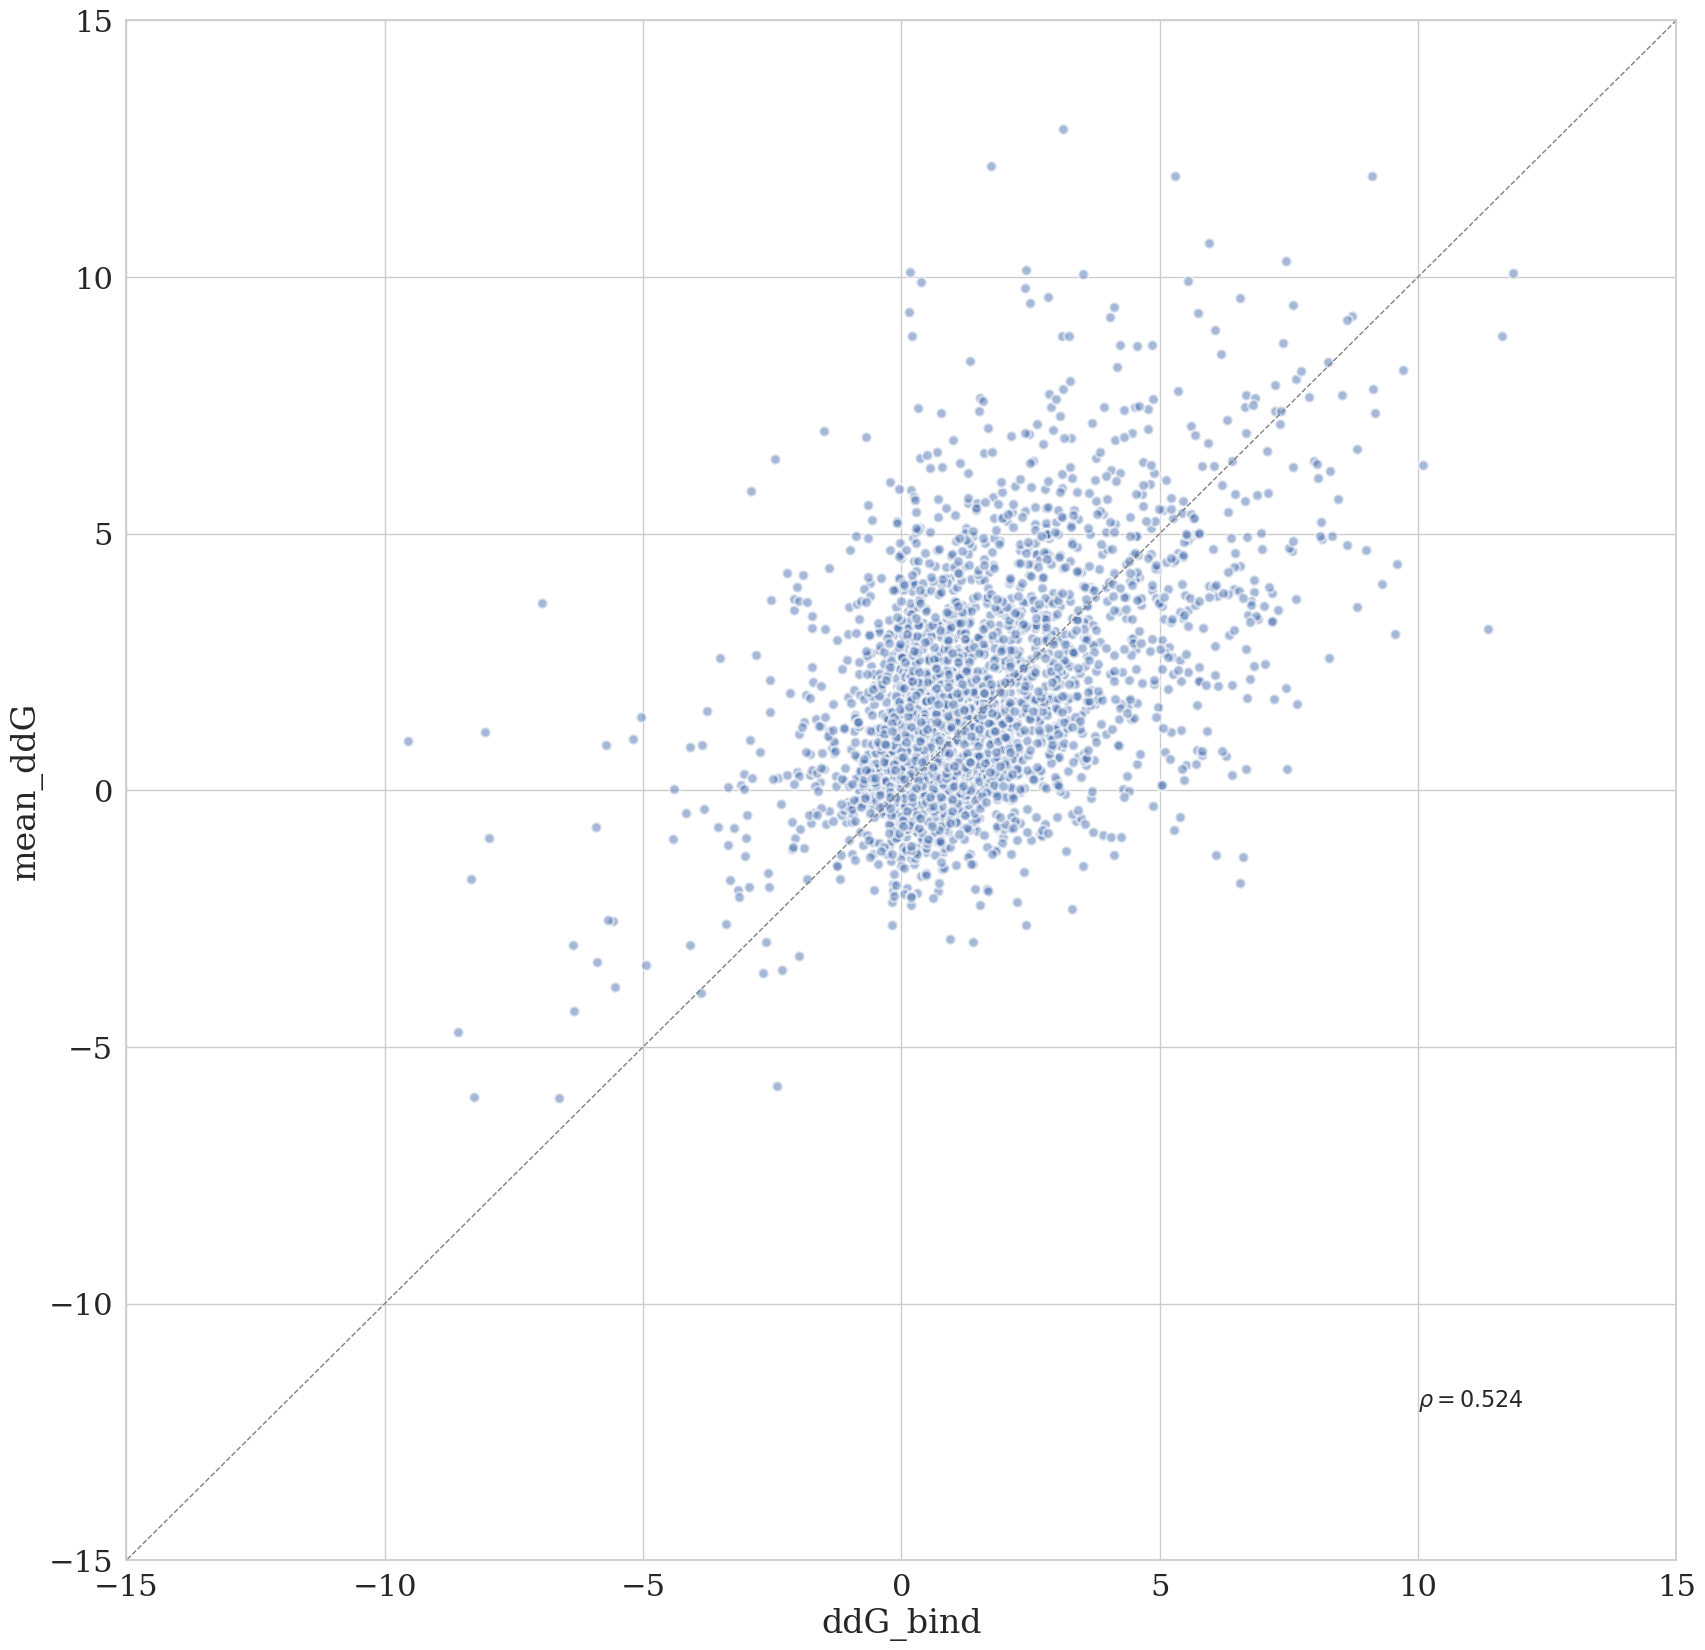

In [35]:
fig, axes = plt.subplots(1,1, figsize = (20,20))
plt.setp(axes, xlim=(-15, 15), ylim=(-15, 15))
# Create the scatter plot

plot = sns.scatterplot(x=plot_data.dropna()['ddG_bind'],
                       y=plot_data.dropna()['mean_ddG'],
                       alpha=0.5, s=55, linewidth=2)

min_val = -15 - 1.5
max_val = 15 + 1.5
axes.plot([min_val, max_val], [min_val, max_val], color='gray', ls='--', lw=1)
r, p = stats.pearsonr(plot_data.dropna()['ddG_bind'],
                      plot_data.dropna()['mean_ddG'])
axes.annotate(f'$\\rho = {r:.3f}$', xy=(10, -12), fontsize = 16)

In [37]:
exp_cart_ddG_flex_all = pd.merge(exp_cart_ddG_all, total, on=['PDBFileID'], how='left')

KeyError: 'PDBFileID'

In [36]:
total

,PDBFileID,total_score,std
0,1108_1CHO,-1.96102,1.85454
1,4185_4YH7,-0.00177,0.57030
2,2031_1R0R,0.31426,0.70211
3,3736_3SE4,1.14853,0.30699
4,3520_3S9D,1.18053,0.54761
...,...,...,...
4558,739_1A22,0.94014,0.71212
4559,1942_1CHO,5.88850,0.75866
4560,934_1VFB,0.12343,0.23238
4561,2720_1AO7,-0.73154,1.36850


In [48]:
#exp_cart_ddG_flex_all = exp_cart_ddG_flex_all.loc[exp_cart_ddG_flex_all['Method']!='FL']

Text(0, 0.5, 'Predicted')

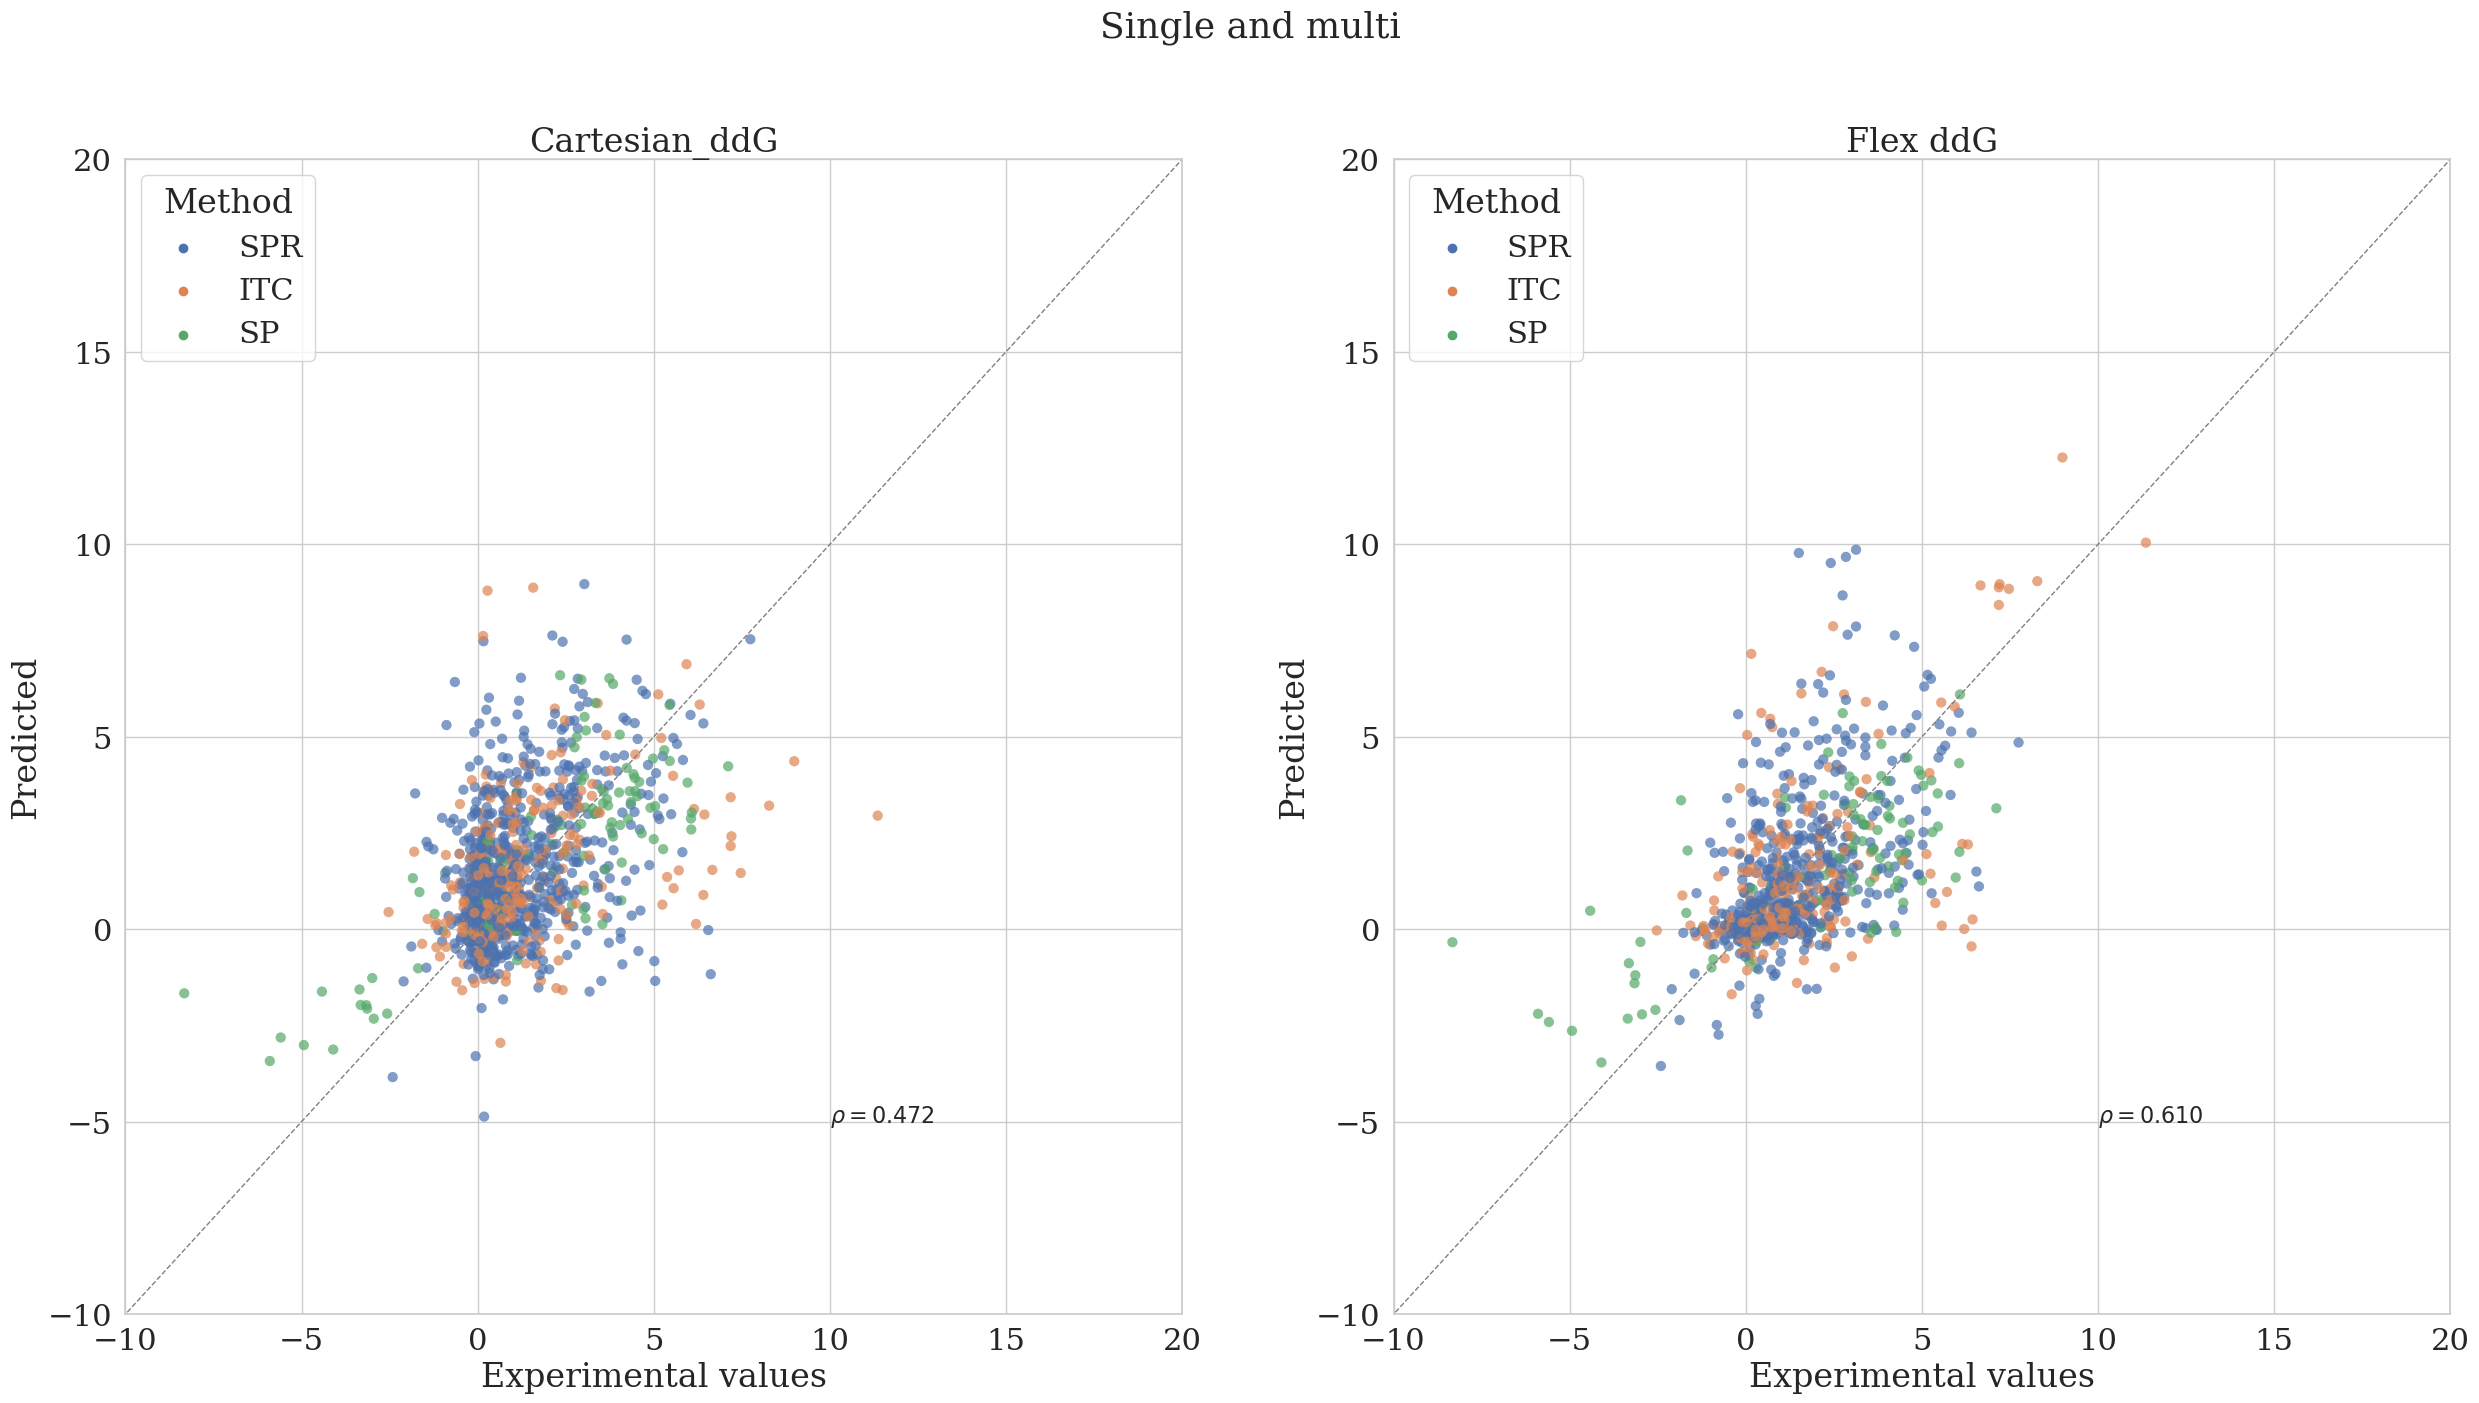

In [49]:
fig, axes = plt.subplots(1,2, figsize = (30,15))
plt.setp(axes, xlim=(-10, 20), ylim=(-10, 20))
min_val = -10 - 1.5
max_val = 20 + 1.5
# Create the scatter plot

sns.scatterplot(x=exp_cart_ddG_flex_all['ddG_bind'],
                y=exp_cart_ddG_flex_all['mean_ddG'],
                alpha=0.7, s=55, linewidth=0, ax=axes[0],
               hue=exp_cart_ddG_flex_all['Method'])

axes[0].plot([min_val, max_val], [min_val, max_val], color='gray', ls='--', lw=1)

r, p = stats.pearsonr(exp_cart_ddG_flex_all['ddG_bind'],
                      exp_cart_ddG_flex_all['mean_ddG'])
axes[0].annotate(f'$\\rho = {r:.3f}$', xy=(10, -5), fontsize = 16)

axes[0].set_title('Cartesian_ddG')
axes[0].set_xlabel('Experimental values')
axes[0].set_ylabel('Predicted')


sns.scatterplot(x=exp_cart_ddG_flex_all['ddG_bind'],
                y=exp_cart_ddG_flex_all['total_score'],
                alpha=0.7, s=55, linewidth=0, ax=axes[1],
               hue=exp_cart_ddG_flex_all['Method'])

axes[1].plot([min_val, max_val], [min_val, max_val], color='gray', ls='--', lw=1)

r, p = stats.pearsonr(exp_cart_ddG_flex_all['ddG_bind'],
                      exp_cart_ddG_flex_all['total_score'])
axes[1].annotate(f'$\\rho = {r:.3f}$', xy=(10, -5), fontsize = 16)

fig.suptitle('Single and multi', fontsize=26)

axes[1].set_title('Flex ddG')
axes[1].set_xlabel('Experimental values')
axes[1].set_ylabel('Predicted')

#plt.savefig('cart_flex_scatter_method.pdf', bbox_inches='tight')

In [51]:
single_muts = exp_cart_ddG_flex_all.loc[exp_cart_ddG_flex_all['iMutation_Location(s)'].str.split(',').str.len() == 1]

Text(0.5, 0.98, 'Single, location')

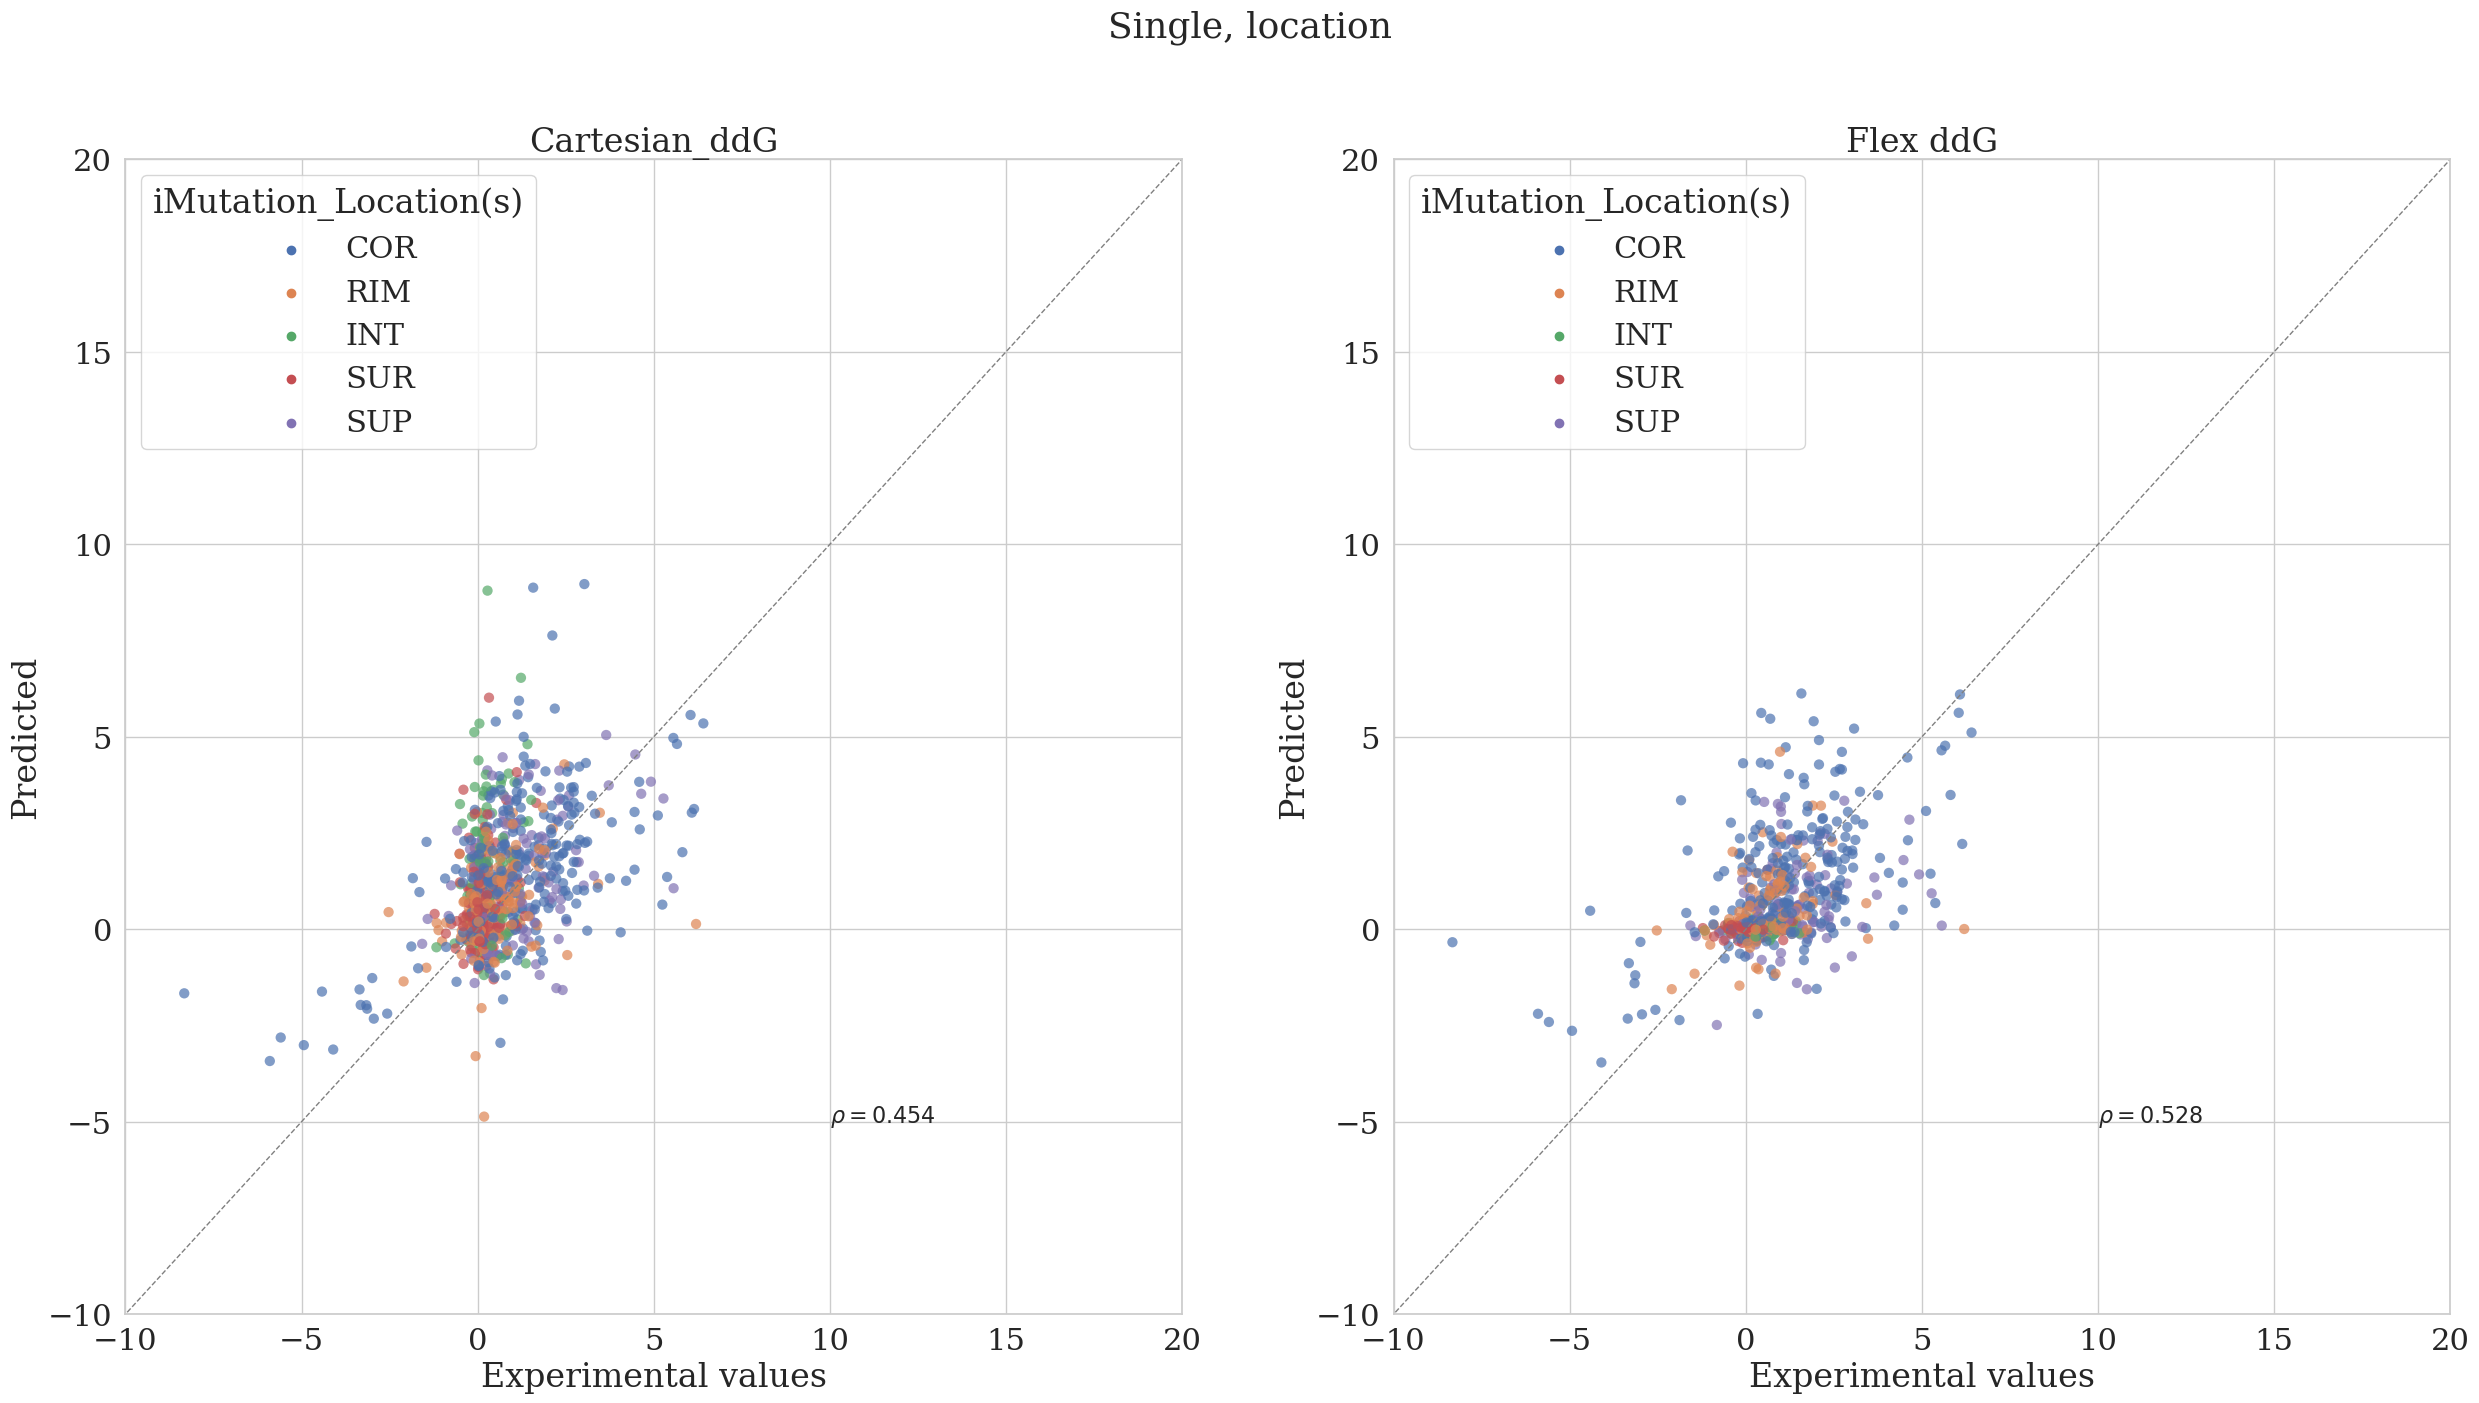

In [55]:
fig, axes = plt.subplots(1,2, figsize = (30,15))
plt.setp(axes, xlim=(-10, 20), ylim=(-10, 20))
min_val = -10 - 1.5
max_val = 20 + 1.5
# Create the scatter plot

sns.scatterplot(x=single_muts['ddG_bind'],
                y=single_muts['mean_ddG'],
                alpha=0.7, s=55, linewidth=0, ax=axes[0],
               hue=single_muts['iMutation_Location(s)'])

axes[0].plot([min_val, max_val], [min_val, max_val], color='gray', ls='--', lw=1)

r, p = stats.pearsonr(single_muts['ddG_bind'],
                      single_muts['mean_ddG'])
axes[0].annotate(f'$\\rho = {r:.3f}$', xy=(10, -5), fontsize = 16)

axes[0].set_title('Cartesian_ddG')
axes[0].set_xlabel('Experimental values')
axes[0].set_ylabel('Predicted')


sns.scatterplot(x=single_muts['ddG_bind'],
                y=single_muts['total_score'],
                alpha=0.7, s=55, linewidth=0, ax=axes[1],
               hue=single_muts['iMutation_Location(s)'])

axes[1].plot([min_val, max_val], [min_val, max_val], color='gray', ls='--', lw=1)

r, p = stats.pearsonr(single_muts['ddG_bind'],
                      single_muts['total_score'])
axes[1].annotate(f'$\\rho = {r:.3f}$', xy=(10, -5), fontsize = 16)

axes[1].set_title('Flex ddG')
axes[1].set_xlabel('Experimental values')
axes[1].set_ylabel('Predicted')

fig.suptitle('Single, location', fontsize=26)
#plt.savefig('cart_flex_scatter_sing_location.pdf', bbox_inches='tight')

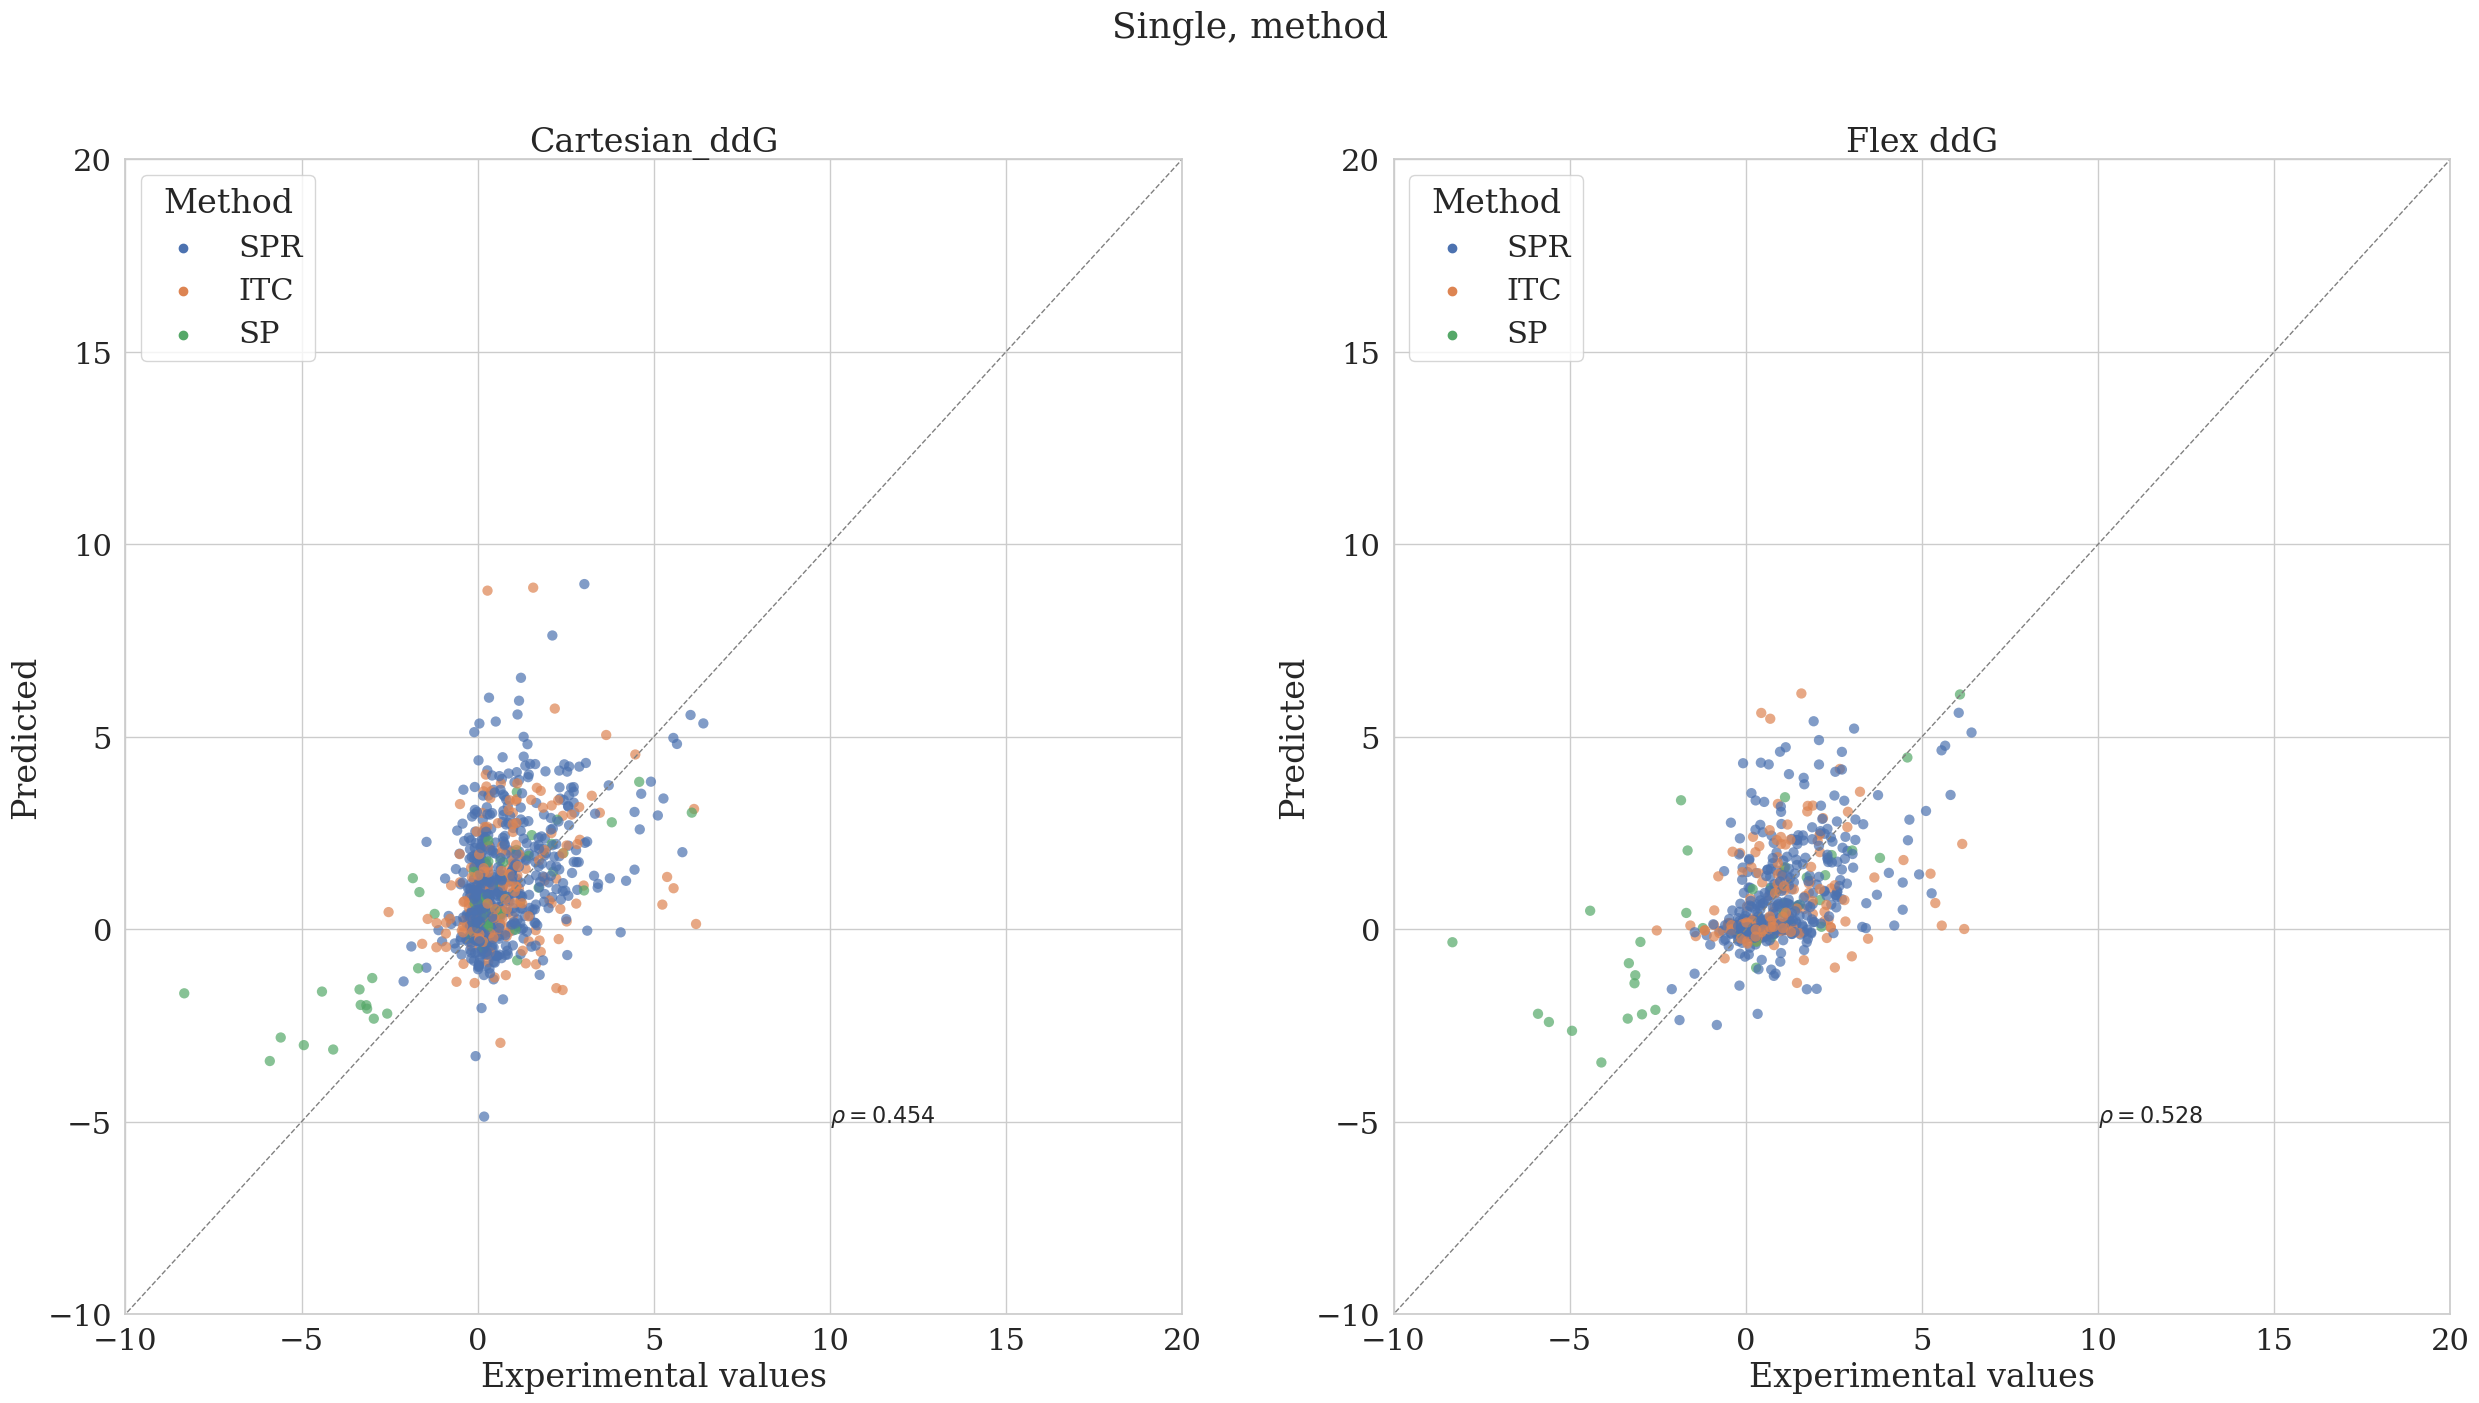

In [57]:
fig, axes = plt.subplots(1,2, figsize = (30,15))
plt.setp(axes, xlim=(-10, 20), ylim=(-10, 20))
min_val = -10 - 1.5
max_val = 20 + 1.5
# Create the scatter plot

sns.scatterplot(x=single_muts['ddG_bind'],
                y=single_muts['mean_ddG'],
                alpha=0.7, s=55, linewidth=0, ax=axes[0],
               hue=single_muts['Method'])

axes[0].plot([min_val, max_val], [min_val, max_val], color='gray', ls='--', lw=1)

r, p = stats.pearsonr(single_muts['ddG_bind'],
                      single_muts['mean_ddG'])
axes[0].annotate(f'$\\rho = {r:.3f}$', xy=(10, -5), fontsize = 16)

axes[0].set_title('Cartesian_ddG')
axes[0].set_xlabel('Experimental values')
axes[0].set_ylabel('Predicted')


sns.scatterplot(x=single_muts['ddG_bind'],
                y=single_muts['total_score'],
                alpha=0.7, s=55, linewidth=0, ax=axes[1],
               hue=single_muts['Method'])

axes[1].plot([min_val, max_val], [min_val, max_val], color='gray', ls='--', lw=1)

r, p = stats.pearsonr(single_muts['ddG_bind'],
                      single_muts['total_score'])
axes[1].annotate(f'$\\rho = {r:.3f}$', xy=(10, -5), fontsize = 16)

axes[1].set_title('Flex ddG')
axes[1].set_xlabel('Experimental values')
axes[1].set_ylabel('Predicted')

fig.suptitle('Single, method', fontsize=26)
#plt.savefig('cart_flex_scatter_sing_method.pdf', bbox_inches='tight')

In [12]:
# Get Cartesian_ddG pipeline scores
positions = []
substitutions = []
indexes = []
for index, row in exp_cart_ddG_all_snp.iterrows():
    #positions.append(int(re.search(r'\d+', row['variant']).group()))
    substitutions.append(list(row['variant'])[-1])
    #indexes.append(index)
#exp_cart_ddG_all_snp = exp_cart_ddG_all_snp.iloc[indexes].copy()
#exp_cart_ddG_all_snp['pos'] = positions
exp_cart_ddG_all_snp['sub'] = substitutions
#exp_cart_ddG_all_snp.loc[ddG_pipeline['mean_ddG'] > 10, 'mean_ddG'] = 10

/tmp/ipykernel_46991/3937874143.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_cart_ddG_all_snp['sub'] = substitutions


In [13]:
# some mistakes in pipeline.txt files generation
zemu_chain[zemu_chain.isna().any(axis=1)]

,variant_by_chain,mean_ddG,std_ddG,PDBFileID,chain,DataSetID,Resolution,Mutations,ExperimentalDDG,variant


In [41]:
test_no_neuts = exp_cart_ddG_all_snp.loc[abs(exp_cart_ddG_all_snp['ExperimentalDDG']) > 0.5]

In [42]:
test_no_neuts

,variant_by_chain,mean_ddG_mono,std_ddG_mono,PDBFileID,chain,DataSetID,Resolution,Mutations,ExperimentalDDG,variant,mean_ddG_complex,std_ddG_complex,quasi_ddG_bind,sub
0,F2W,0.801034,0.037795,2JEL,P,398.0,2.5,P F2W,2.62,F437W,0.671839,1.010260e-01,-0.129195,W
2,Q3K,-0.208391,0.470917,2JEL,P,399.0,2.5,P Q3K,4.09,Q438K,1.723678,2.582205e-01,1.932069,K
3,Q4K,0.963793,0.001389,2JEL,P,400.0,2.5,P Q4K,1.36,Q439K,3.317931,6.688431e-03,2.354138,K
5,E5Q,-0.002414,0.000000,2JEL,P,402.0,2.5,P E5Q,0.71,E440Q,0.368046,5.038648e-01,0.370460,Q
18,S41C,0.472644,0.065407,2JEL,P,415.0,2.5,P S41C,1.50,S476C,1.195517,1.869363e-02,0.722874,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1125,D53A,3.495517,0.003165,1DAN,T,848.0,2.0,T D58A,2.00,D439A,3.625172,0.000000e+00,0.129655,A
1126,D53E,2.596092,0.497251,1DAN,T,847.0,2.0,T D58E,1.38,D439E,4.220575,1.415839e-01,1.624483,E
1128,T55A,1.323448,0.000000,1DAN,T,889.0,2.0,T T60A,2.31,T441A,1.534368,2.220446e-16,0.210920,A
1139,F71A,1.780345,0.000000,1DAN,T,882.0,2.0,T F76A,1.15,F457A,3.782759,7.777117e-03,2.002414,A


Pearson:  0.45221617678177545
Spearman:  0.37450003826736805


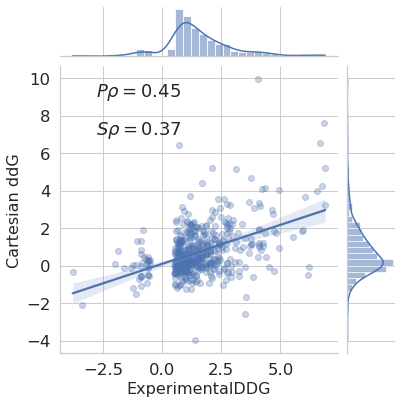

In [43]:
a = sns.jointplot(x=test_no_neuts['ExperimentalDDG'], y=test_no_neuts['quasi_ddG_bind'], kind="reg", scatter_kws={'alpha':0.3})
# ylim = (-3.5,11), xlim = (-4,11)
a.set_axis_labels('ExperimentalDDG', 'Cartesian ddG', fontsize=16)
pr, pp = stats.pearsonr(test_no_neuts['ExperimentalDDG'], test_no_neuts['quasi_ddG_bind'])
sr, sp = stats.spearmanr(test_no_neuts['ExperimentalDDG'], test_no_neuts['quasi_ddG_bind'])
print('Pearson: ', pr)
print('Spearman: ', sr)
a.ax_joint.annotate(f'$P\\rho={pr:.2f}$', xy=(-2.8, 9))
a.ax_joint.annotate(f'$S\\rho={sr:.2f}$', xy=(-2.8, 7))
# a.fig.suptitle('Flex ddG stability vs Cartesian ddG', fontsize = 'medium')
# a.fig.tight_layout()
a.savefig(os.path.join(pic_path, 'Cart_ddG_SKEMPI_b_ddG_SPM_no_neuts.pdf'), format='pdf')

In [ ]:
# display(variants[variants['PDBFileID'] == '2JEL'])
# display(zemu[zemu['Mutations'] == 'A Y153A'])
display(zemu[zemu['PDBFileID'] == '1A4Y'])

In [13]:
pr, pp = stats.pearsonr(exp_cart_ddG_all_snp['ExperimentalDDG'], exp_cart_ddG_all_snp['quasi_ddG_bind'])
sr, sp = stats.spearmanr(exp_cart_ddG_all_snp['ExperimentalDDG'], exp_cart_ddG_all_snp['quasi_ddG_bind'])
print('Pearson: ', pr, pp)
print('Spearman: ', sr, sp)

Pearson:  0.49856683915714706 9.018508699516449e-63
Spearman:  0.375007282011701 4.081518723450915e-34


In [15]:
exp_cart_ddG_all_snp.corr(method='spearman')

,mean_ddG_mono,std_ddG_mono,DataSetID,Resolution,ExperimentalDDG,mean_ddG_complex,std_ddG_complex,quasi_ddG_bind
mean_ddG_mono,1.000000,0.037508,0.014932,-0.015817,0.123260,0.715526,0.019466,-0.057019
std_ddG_mono,0.037508,1.000000,0.041757,0.254271,0.020433,0.013175,0.208647,-0.014442
DataSetID,0.014932,0.041757,1.000000,0.047248,-0.011458,0.011996,-0.000763,-0.029882
Resolution,-0.015817,0.254271,0.047248,1.000000,-0.123926,-0.081307,0.052805,-0.064661
ExperimentalDDG,0.123260,0.020433,-0.011458,-0.123926,1.000000,0.369915,0.131929,0.375007
mean_ddG_complex,0.715526,0.013175,0.011996,-0.081307,0.369915,1.000000,0.110517,0.571637
std_ddG_complex,0.019466,0.208647,-0.000763,0.052805,0.131929,0.110517,1.000000,0.139388
quasi_ddG_bind,-0.057019,-0.014442,-0.029882,-0.064661,0.375007,0.571637,0.139388,1.000000


Pearson:  0.49856683915714706
Spearman:  0.375007282011701


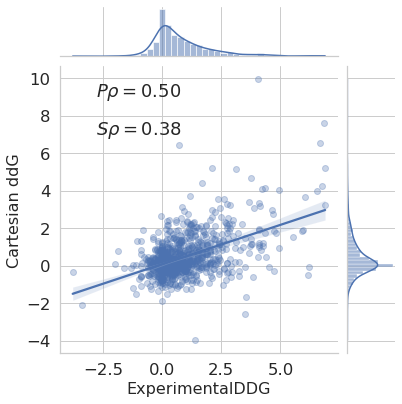

In [23]:
a = sns.jointplot(x=exp_cart_ddG_all_snp['ExperimentalDDG'], y=exp_cart_ddG_all_snp['quasi_ddG_bind'], kind="reg", scatter_kws={'alpha':0.3})
# ylim = (-3.5,11), xlim = (-4,11)
a.set_axis_labels('ExperimentalDDG', 'Cartesian ddG', fontsize=16)
pr, pp = stats.pearsonr(exp_cart_ddG_all_snp['ExperimentalDDG'], exp_cart_ddG_all_snp['quasi_ddG_bind'])
sr, sp = stats.spearmanr(exp_cart_ddG_all_snp['ExperimentalDDG'], exp_cart_ddG_all_snp['quasi_ddG_bind'])
print('Pearson: ', pr)
print('Spearman: ', sr)
a.ax_joint.annotate(f'$P\\rho={pr:.2f}$', xy=(-2.8, 9))
a.ax_joint.annotate(f'$S\\rho={sr:.2f}$', xy=(-2.8, 7))
# a.fig.suptitle('Flex ddG stability vs Cartesian ddG', fontsize = 'medium')
# a.fig.tight_layout()
a.savefig(os.path.join(pic_path, 'Cart_ddG_SKEMPI_b_ddG_SPM.pdf'), format='pdf')

In [27]:
min(exp_cart_ddG_all_snp['quasi_ddG_bind'])

-3.9726436781609475

Pearson:  0.4561397809966684
Spearman:  0.3732201504614237


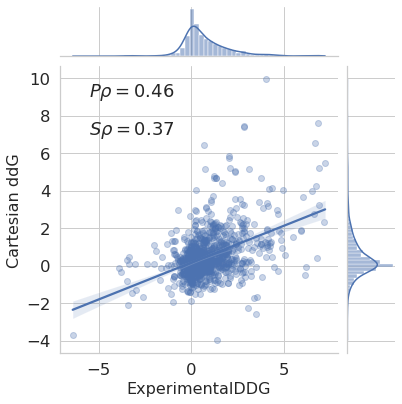

In [11]:
a = sns.jointplot(x=exp_cart_ddG_all['ExperimentalDDG'], y=exp_cart_ddG_all['quasi_ddG_bind'], kind="reg", scatter_kws={'alpha':0.3})
# ylim = (-3.5,11), xlim = (-4,11)
a.set_axis_labels('ExperimentalDDG', 'Cartesian ddG', fontsize=16)
pr, pp = stats.pearsonr(exp_cart_ddG_all['ExperimentalDDG'], exp_cart_ddG_all['quasi_ddG_bind'])
sr, sp = stats.spearmanr(exp_cart_ddG_all['ExperimentalDDG'], exp_cart_ddG_all['quasi_ddG_bind'])
print('Pearson: ', pr)
print('Spearman: ', sr)
a.ax_joint.annotate(f'$P\\rho={pr:.2f}$', xy=(-5.5, 9))
a.ax_joint.annotate(f'$S\\rho={sr:.2f}$', xy=(-5.5, 7))
# a.fig.suptitle('Flex ddG stability vs Cartesian ddG', fontsize = 'medium')
# a.fig.tight_layout()
a.savefig(os.path.join(pic_path, 'Cart_ddG_SKEMPI_test_b_ddG.pdf'), format='pdf')

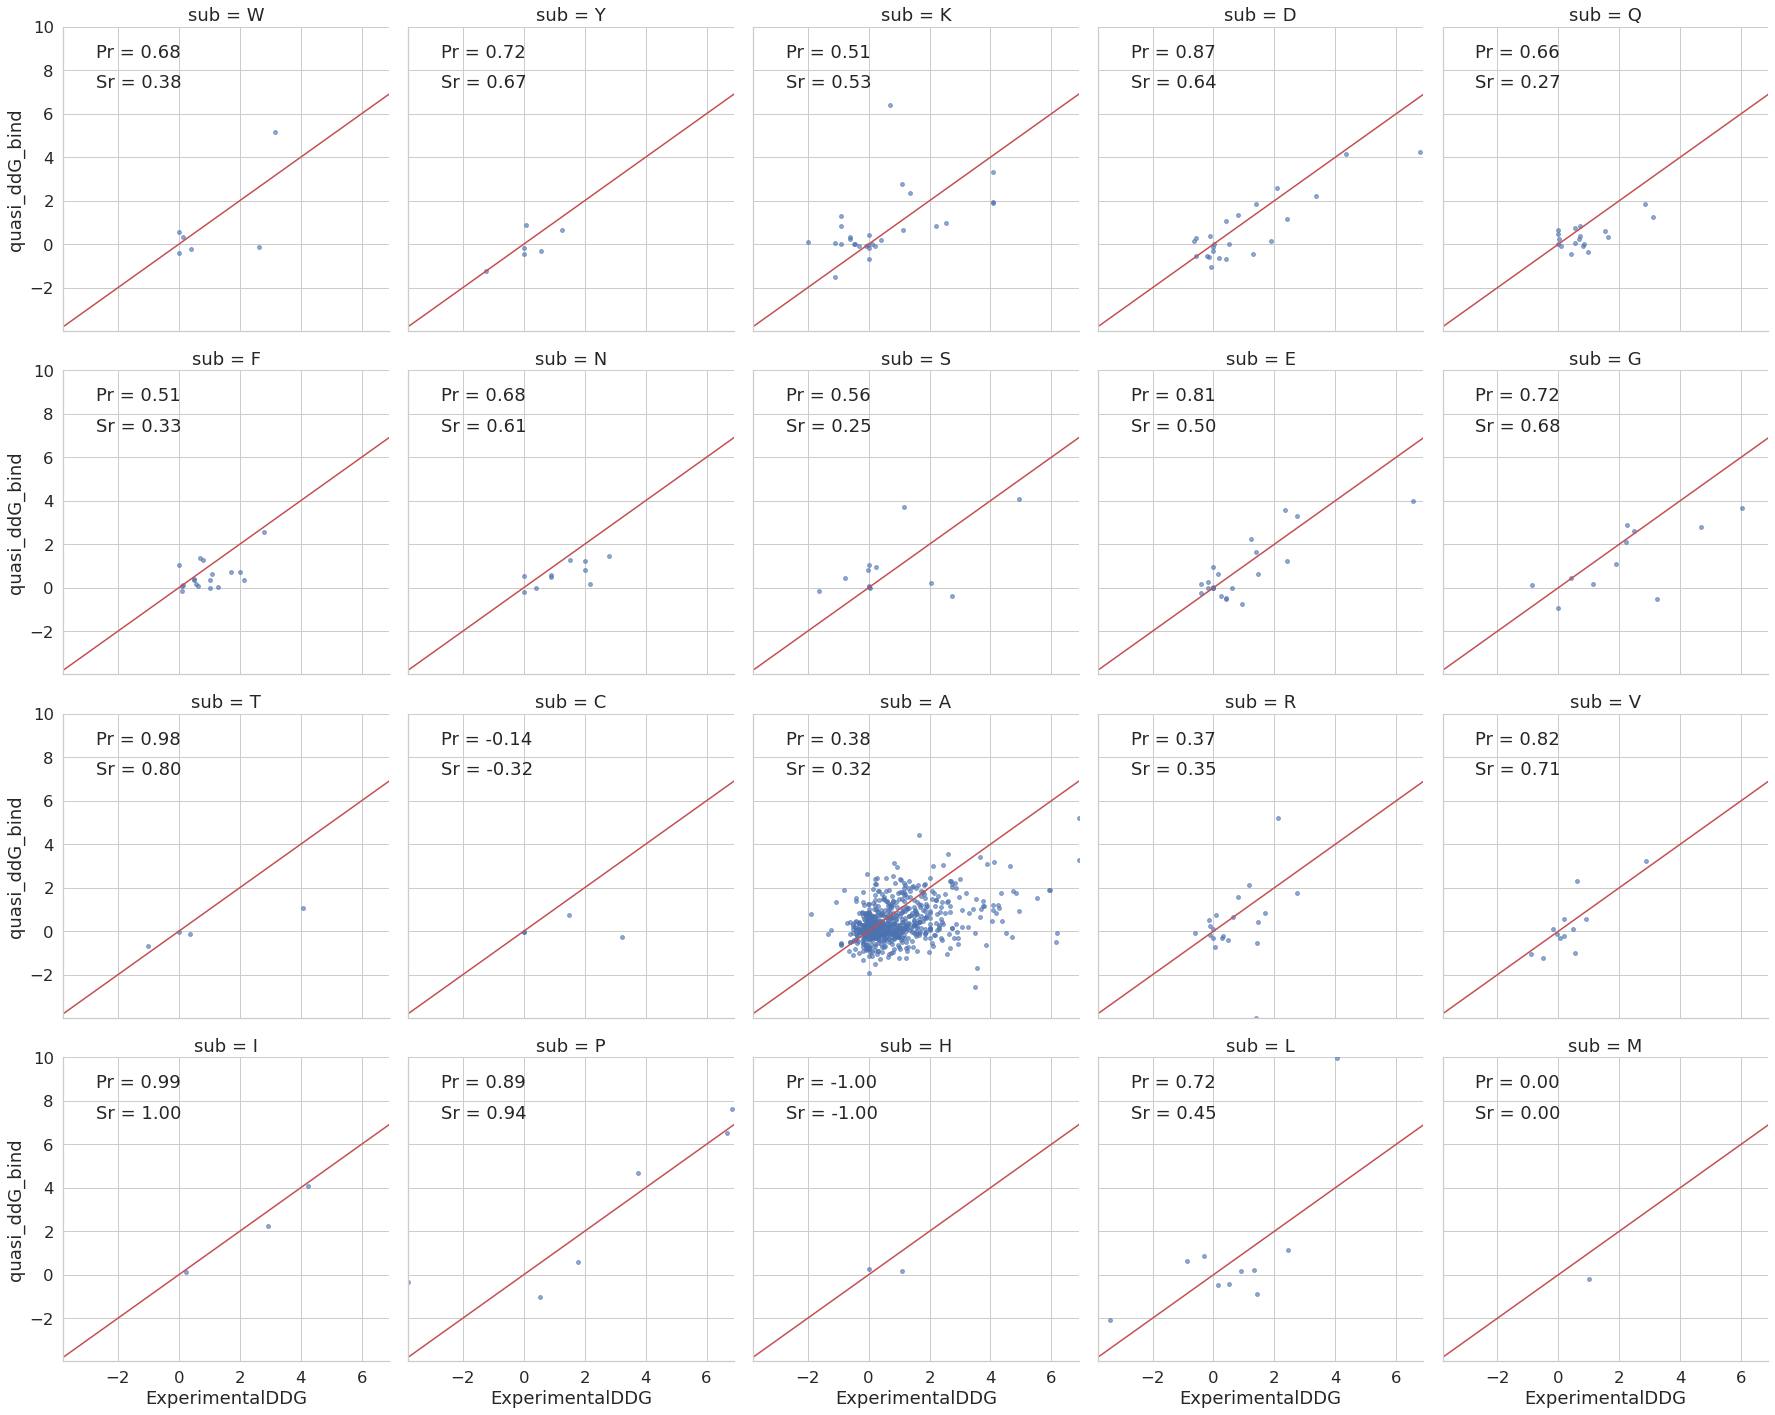

In [30]:
def corrfunc(x, y, **kws):
    try:
        pr, _ = stats.pearsonr(x, y)
        sr, _ = stats.spearmanr(x, y)
    except:
        sr = 0
        pr = 0
    ax = plt.gca()
    ax.annotate("Pr = {:.2f}".format(pr),
                xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate("Sr = {:.2f}".format(sr),
                xy=(.1, .8), xycoords=ax.transAxes)

X_plot = [-4, 10]
Y_plot = [-4, 10]
    
g = sns.FacetGrid(exp_cart_ddG_all_snp, col ='sub', col_wrap=5, height=5)
g.set(xlim=(-3.79, 6.89), ylim=(-3.98, 10))
g.map(plt.scatter, "ExperimentalDDG", "quasi_ddG_bind", alpha=.6, s=15)
g.map(corrfunc, "ExperimentalDDG", "quasi_ddG_bind")

for ax in g.axes.flat:
    ax.plot(X_plot, Y_plot, color='r')

plt.savefig(os.path.join(pic_path, 'Cart_ddG_bddG_SPM_per_aa.pdf'), format='pdf')